In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dataframes complementarios (Traducción de IDs)                                         # 1ra Columna   -> Resto de columnas
df_id_banco = pd.read_csv("Data/ExtraccionDomiVersionFinal/CatBanco.csv")                # ID Banco      -> Nombre del banco
df_id_emisora = pd.read_csv("Data/CatEmisora_new.csv")                                   # ID Emisora    -> Nombre Emisora, ID Banco, Emisora??, Tipo envío
df_id_respuesta = pd.read_csv("Data/ExtraccionDomiVersionFinal/CatRespuestaBancos.csv")  # ID Respuesta  -> Descripción
df_id_listaemisor = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroEmisora.csv") # ID ListaCobro -> ID Emisora

# Dataframes detallados por año
df_2022 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2022.csv")
df_2023 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")
df_2024 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2024.csv")
df_2025 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2025.csv")

C:\Users\Jose Armando\AppData\Local\Temp\ipykernel_22964\3664424642.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("Data/ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")


In [3]:
cobros_detallados = pd.concat([df_2022, df_2023, df_2024, df_2025], ignore_index=True)
cobros_detallados.rename(columns={
    'idRespuestaBanco': 'IdRespuestaBanco',
    'idBanco': 'IdBanco'
}, inplace=True)

cobros_detallados.head()

,idListaCobro,idCredito,consecutivoCobro,IdBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,IdRespuestaBanco
0,100613,83021,27169966,2,572.24,572.24,0.0,NaN,04
1,100613,87227,27169937,2,517.74,517.74,0.0,NaN,04
2,100613,103785,27169946,2,681.23,681.23,0.0,NaN,04
3,100613,110463,27169969,2,572.24,572.24,0.0,NaN,04
4,100613,113755,27169948,2,340.62,340.62,0.0,NaN,04


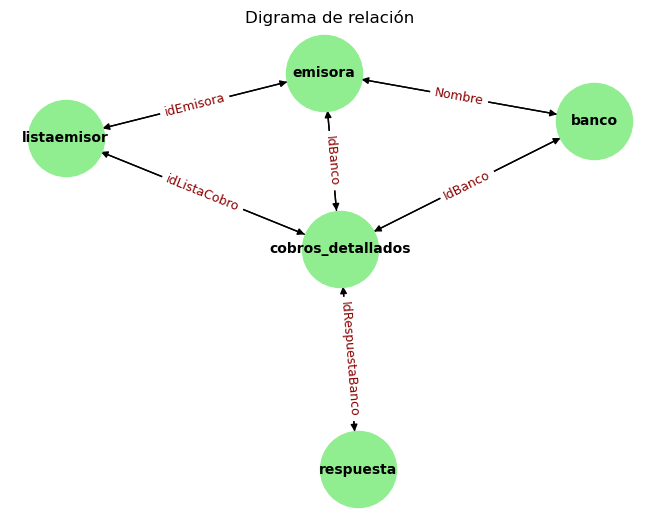

In [4]:
import networkx as nx

dataframes = {
    "banco": df_id_banco,
    "emisora": df_id_emisora,
    "respuesta": df_id_respuesta,
    "listaemisor": df_id_listaemisor,
    "cobros_detallados": cobros_detallados
}

G = nx.DiGraph()

# Agregar nodos
for name in dataframes:
    G.add_node(name)

# Comparar y detectar relaciones
for table_a, df_a in dataframes.items():
    for table_b, df_b in dataframes.items():
        if table_a != table_b:
            shared_keys = set(df_a.columns).intersection(df_b.columns)
            for key in shared_keys:
                G.add_edge(table_b, table_a, label=key)

# Graficar grafo
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=3000, font_size=10, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="darkred", font_size=9)

plt.title("Digrama de relación")
plt.show()


In [5]:
# Chequeo de cobros exitosos

cobros_exitosos = cobros_detallados[cobros_detallados['IdRespuestaBanco'].isin([0, 0.0])]
monto_exigible_exito = cobros_exitosos['montoExigible'].sum()
monto_cobrado_exito = cobros_exitosos['montoCobrado'].sum()
print(f"De los cobros exitosos se logró cobrar ${monto_cobrado_exito:.2f} de los ${monto_exigible_exito:.2f} exigidos")

De los cobros exitosos se logró cobrar $222597974.35 de los $225481614.75 exigidos


In [6]:
chequeo = cobros_detallados[cobros_detallados['montoCobrado'] > 1]
chequeo.head
monto_exigible_chequeo = chequeo['montoExigible'].sum()
monto_cobrado_chequeo = chequeo['montoCobrado'].sum()
print(f"De los cobros exitosos se logró cobrar ${monto_cobrado_chequeo:.2f} de los ${monto_exigible_chequeo:.2f} exigidos")

De los cobros exitosos se logró cobrar $306252666.48 de los $308430834.94 exigidos


In [7]:
chequeo['IdRespuestaBanco'].value_counts()

IdRespuestaBanco
0.0    274136
00      18480
04          6
Name: count, dtype: int64

In [8]:
chequeo2 = chequeo[chequeo['IdRespuestaBanco'] != '04']
chequeo2.head
monto_exigible_chequeo2 = chequeo2['montoExigible'].sum()
monto_cobrado_chequeo2 = chequeo2['montoCobrado'].sum()
print(f"De los cobros exitosos se logró cobrar ${monto_cobrado_chequeo2:.2f} de los ${monto_exigible_chequeo2:.2f} exigidos")

De los cobros exitosos se logró cobrar $306242966.17 de los $308421134.63 exigidos


In [9]:
cobros_0 = chequeo2
cobros_0_filt = cobros_0.merge(df_id_listaemisor[['idListaCobro', 'idEmisora']], on='idListaCobro', how='left')
#cobros_0 = cobros_0.merge(df_id_listaemisor[['idListaCobro', 'idEmisora']], on='idListaCobro', how='left')
#cobros_0_filt = cobros_0[cobros_0['idEmisora'] < 26] # Filtado para omitir datos incorrectos de las emisoras
cobros_0_filt.head()

,idListaCobro,idCredito,consecutivoCobro,IdBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,IdRespuestaBanco,idEmisora
0,100551,424794,27163745,21,1366.89,1366.89,1366.89,29/09/2022,00,20
1,100551,488023,27163762,44,654.79,654.79,654.79,29/09/2022,00,20
2,100551,606495,27163677,21,1354.67,1354.67,1354.67,29/09/2022,00,20
3,97333,599055,26666422,2,3531.06,3531.06,3531.06,25/08/2022,00,78
4,101262,490653,27243353,21,318.07,318.07,318.07,10/10/2022,00,20


In [10]:
#cobros_0.shape

In [11]:
cobros_0_filt.shape

(376773, 10)

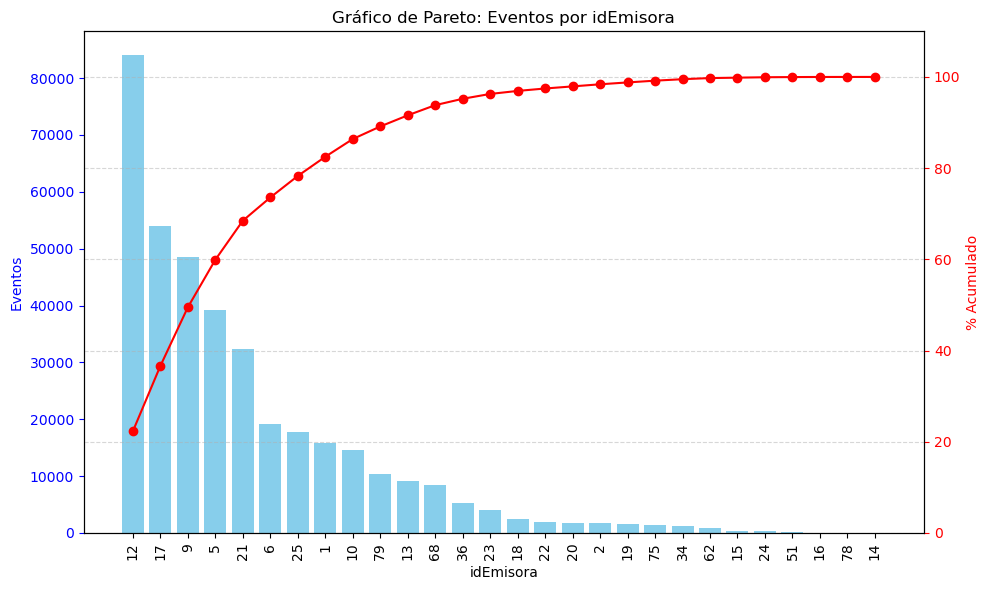

In [12]:
counts = cobros_0_filt['idEmisora'].value_counts() # Frecuencias
counts = counts.sort_values(ascending=False) # Sorteo
cum_percent = counts.cumsum() / counts.sum() * 100 # Porcentaje acumulado

# Gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras de frecuencia
ax1.bar(counts.index.astype(str), counts.values, color='skyblue')
ax1.set_xlabel('idEmisora')
ax1.set_ylabel('Eventos', color='blue')
ax1.tick_params('y', colors='blue')
plt.xticks(rotation=90)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(counts.index.astype(str), cum_percent.values, color='red', marker='o')
ax2.set_ylabel('% Acumulado', color='red')
ax2.tick_params('y', colors='red')
ax2.set_ylim(0, 110)

# Título
plt.title("Gráfico de Pareto: Eventos por idEmisora")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


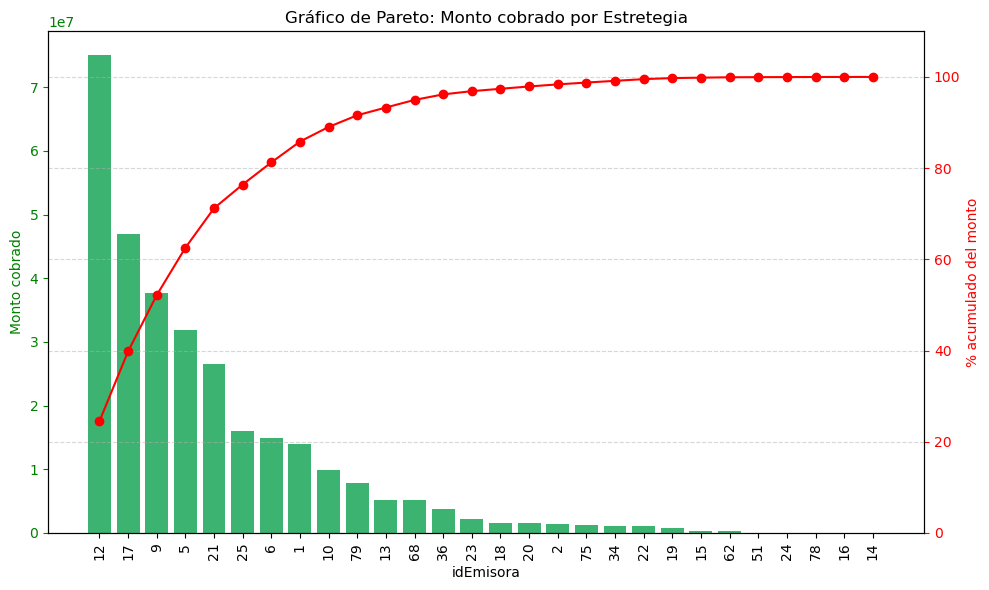

In [13]:
# Paso 1: Agrupar por idEmisora y sumar los montos cobrados
monto_por_emisora = cobros_0_filt.groupby('idEmisora')['montoCobrado'].sum()

# Paso 2: Ordenar de mayor a menor
monto_ordenado = monto_por_emisora.sort_values(ascending=False)

# Paso 3: Calcular porcentaje acumulado
porcentaje_acumulado = monto_ordenado.cumsum() / monto_ordenado.sum() * 100

# Paso 4: Graficar Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras de monto total cobrado
ax1.bar(monto_ordenado.index.astype(str), monto_ordenado.values, color='mediumseagreen')
ax1.set_xlabel('idEmisora')
ax1.set_ylabel('Monto cobrado', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(monto_ordenado.index.astype(str), porcentaje_acumulado.values, color='red', marker='o')
ax2.set_ylabel('% acumulado del monto', color='red')
ax2.tick_params('y', colors='red')
ax2.set_ylim(0, 110)

# Título
plt.title("Gráfico de Pareto: Monto cobrado por Estretegia")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [23]:
df_pagare = pd.read_csv("Data/Capital_Pagare_FechaAperturaCredito.csv")
df_pagare.head()

,idcredito,pagare,capital,fechaAperturaCredito
0,10456,120379.68,50000.0,26/05/2008
1,10439,122306.40,50800.0,03/06/2008
2,10297,132333.12,46000.0,09/06/2008
3,10327,77535.84,40000.0,13/06/2008
4,10073,96304.32,40000.0,30/06/2008


In [24]:
df_pagare.describe()

,idcredito,pagare,capital
count,97228.000000,9.722800e+04,97228.000000
mean,553297.709034,7.012854e+04,29178.365835
std,149774.631271,7.141149e+04,27907.457229
min,6.000000,1.320800e+02,60.570000
25%,468719.250000,2.825913e+04,12100.000000
50%,588682.000000,4.868474e+04,20196.500000
75%,667805.250000,8.416710e+04,35000.000000
max,756595.000000,1.000040e+06,376769.000000


In [26]:
df_pagare.isna().sum()

idcredito               0
pagare                  0
capital                 0
fechaAperturaCredito    0
dtype: int64

In [28]:
df_pagare['fechaAperturaCredito'].dtype

dtype('O')

In [31]:
df_pagare['fechaAperturaCredito'] = pd.to_datetime(df_pagare['fechaAperturaCredito'], errors='coerce')
df_pagare = df_pagare.sort_values('fechaAperturaCredito')
df_pagare.tail()

,idcredito,pagare,capital,fechaAperturaCredito
96680,755592,42141.12,14999.0,2025-05-07
96682,755604,28646.40,10196.0,2025-05-07
96694,755726,163799.48,58300.0,2025-05-08
96695,755859,152297.08,54206.0,2025-05-09
96696,756595,21071.96,7500.0,2025-05-15


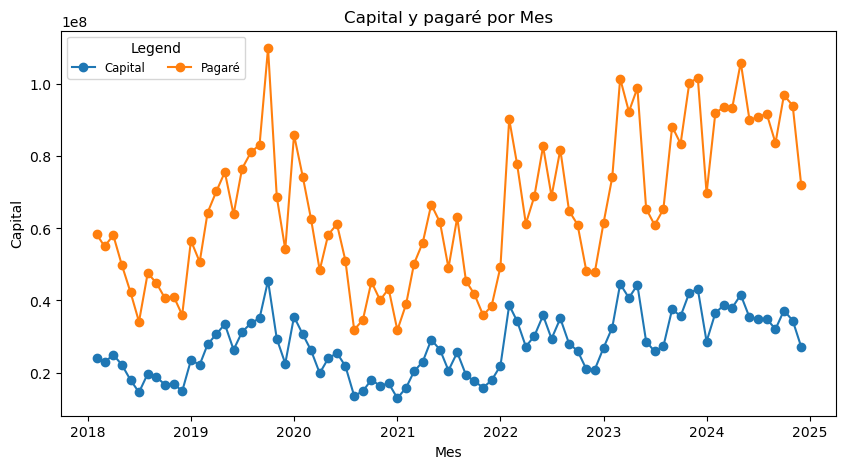

In [59]:
# Crédito en base a meses

df_pagare['mes'] = df_pagare['fechaAperturaCredito'].dt.to_period('M')  
df_mensual = df_pagare.groupby('mes')[['capital', 'pagare']].sum().reset_index()
df_mensual['mes'] = df_mensual['mes'].dt.to_timestamp()
df_mensual = df_mensual.iloc[:-5]
df_mensual = df_mensual.iloc[105:]

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(df_mensual['mes'], df_mensual['capital'], marker='o', label='Capital')
plt.plot(df_mensual['mes'], df_mensual['pagare'], marker='o', label='Pagaré')
plt.title('Capital y pagaré por Mes')
plt.xlabel('Mes')
plt.ylabel('Capital')
plt.legend(loc='upper left', fontsize='small', ncol=2, title='Legend')
plt.show()

In [60]:
df_mensual.describe()

,mes,capital,pagare
count,83,8.300000e+01,8.300000e+01
mean,2021-07-01 12:26:01.445783040,2.745451e+07,6.567320e+07
min,2018-02-01 00:00:00,1.288394e+07,3.175625e+07
25%,2019-10-16 12:00:00,2.069317e+07,4.871348e+07
50%,2021-07-01 00:00:00,2.683988e+07,6.304720e+07
75%,2023-03-16 12:00:00,3.465879e+07,8.298690e+07
max,2024-12-01 00:00:00,4.549812e+07,1.099906e+08
std,NaN,8.431845e+06,2.058336e+07
